# 2023-Summer FIRM Lab RA - Bitcoin Price Prediction

In [144]:
from binance.client import Client
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
import requests
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM, Bidirectional
import ccxt
from datetime import datetime, timedelta
import pyupbit


In [145]:
class My_Upbit_Data():
    
    def __init__(self,coinid='BTC'):
        
        self.coinid = coinid

    def __load_data(self, interval='minute1', date=None, rows=1000):
        dfs = []
        
        ranges = int(rows/200)
        
        for i in range(ranges):
            df = pyupbit.get_ohlcv(ticker='KRW-'+self.coinid, interval=interval, to=date)
            dfs.append(df)

            date = df.index[0]
            time.sleep(0.15)

        df = pd.concat(dfs).sort_index()
        
        return df
    
    def load_ml_data(self,interval='minute1',rows=20000):
        dataframe = self.__load_data(interval=interval, rows=rows)
        times = dataframe.index

        return [times,dataframe]

In [170]:
class My_Lstm:
    def windowed_dataset(self, series, window_size, batch_size, shuffle_buffer):
        series = tf.expand_dims(series, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(series)
        ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
        ds = ds.flat_map(lambda w: w.batch(window_size + 1))
        ds = ds.shuffle(shuffle_buffer)
        ds = ds.map(lambda w: (w[:-1], w[1:]))

        return ds.batch(batch_size).prefetch(1)

    def __dataframe_to_series(self, dataframe, col='open'):
        data = dataframe

        return np.asarray(data[col], dtype='float32')

    def scale_data_fit(self, series):
        self.min_scale = np.min(series)
        self.max_scale = np.max(series)

    def scale_data(self, series):
        series = np.array(series)
        series -= self.min_scale
        series /= self.max_scale

        return series

    def un_scale_data(self, series):
        series = np.array(series)
        series *= self.max_scale
        series += self.min_scale

        return series

    def keras_layers_compile(self, loss='mse', optimizer='adam', metrics='mse'):

        self.model = tf.keras.Sequential([
            #tf.keras.layers.LSTM(128, input_shape=[None, 1], return_sequences=True, recurrent_dropout=0.2,dropout=0.2),
            # tf.keras.layers.BatchNormalization(input_shape=[None, 1]),
            
            LSTM(64, input_shape=[None, 1], return_sequences=True,),
            Bidirectional(LSTM(128,return_sequences=True,)),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(256),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1)])

        self.model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    def callbacks(self, monitor='loss', mode='min', patience=10):
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 10))
        earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='mse', patience=10)
        ModelCheckpoint = tf.keras.callbacks.ModelCheckpoint(self.h5_name, monitor='loss', save_best_only=True)
    
        return [lr_schedule, earlystop, ModelCheckpoint]
        

    def train_data_load(self, dataframe, col='close', scale=True, train_mode=True, window_size=24, batch_size=16,shuffle_buffer=30000,interval='minute1'):
        self.scale = scale
        self.interval = interval

        # Dataframe to series 하나의 컬럼만 가져와서 예측진행
        series = self.__dataframe_to_series(dataframe, col=col)
        self.times = dataframe.index

        # 원본데이터 백업
        self.backup_series = series

        # Scale 진행 MinMax scale

        if train_mode:
            if self.scale:
                self.scale_data_fit(series)
                series = self.scale_data(series)
        else:
            if self.scale:
                self.scale_data_fit(series)

        # Tensorflow 전용 데이터셋으로 변환 (window size=예측할 날짜수)
        self.window_size = window_size

        if train_mode:
            series = self.windowed_dataset(series, self.window_size, batch_size, shuffle_buffer)

            self.series = series
        else:
            self.series = series

    def train_lstm(self,h5_name, epochs=100, callbacks=None, loss='mae', optimizer='adam', metrics='mae', ):

        self.h5_name = h5_name
        # Keras
        self.keras_layers_compile(loss=loss, optimizer=optimizer, metrics=metrics)
        if callbacks:
            callbacks = self.callbacks()
            self.model.fit(self.series, epochs=epochs, callbacks=callbacks)
        else:
            self.model.fit(self.series, epochs=epochs)


    def save_md(self, name):
        try:
            self.model.save(name)
        except:
            print('Error!')

    def model_load(self, name, compile=True):
        if compile:
            self.keras_layers_compile()
            self.model = tf.keras.models.load_model(name)
        else:
            self.model = tf.keras.models.load_model(name)

    def predict(self, times, ranges=[0, 200]):
        predicts = []
        self.ranges = ranges
        # self.backup_series_to_un_scale = self.un_scale_data(self.backup_series[ranges[0]:ranges[1]])

        self.time_series = times[ranges[0]:ranges[1]]

        ranges_series = self.backup_series[ranges[0]:ranges[1]]

        if self.scale:

            ranges_series_scale = self.scale_data(ranges_series)

            for time in range(len(ranges_series_scale) - self.window_size):
                pred = np.array(ranges_series_scale[time: time + self.window_size])

                pred = pred.reshape(1, -1, 1)

                predict = self.model.predict(pred)

                predicts.append(predict[0][0])
            # 수정부분
            predicts = self.un_scale_data(predicts)
        else:

            for time in range(len(ranges_series) - self.window_size):
                pred = np.array(ranges_series[time: time + self.window_size])

                pred = pred.reshape(1, -1, 1)

                predict = self.model.predict(pred)

                predicts.append(predict[0][0])

        return predicts

    def predict_plot(self, predicts):

        plt.figure(figsize=(12, 8))
        plt.plot(np.array(self.time_series[:-self.window_size]), np.array(predicts), color='red', label='Predict')
        plt.plot(np.array(self.time_series[:-self.window_size]),
                 np.array(self.backup_series[self.ranges[0]:self.ranges[1] - self.window_size]), color='blue', label='Real')
        plt.legend(loc='center left')
        plt.show()

    def predict_last_few(self, future_, minutes=10):

        _last_future_series = self.backup_series[-self.window_size:]

        self.pred_times = self.times[-self.window_size:]
        self.pred_times = self.pred_times.to_list()

        self.future_ = future_
        futures = []

        if self.scale:

            _last_future_series = self.scale_data(_last_future_series)

            for time in range(future_):
                pred = np.array(_last_future_series, dtype='float64')

                pred = pred.reshape(1, -1, 1)

                predict = self.model.predict(pred)

                _last_future_series = np.append(_last_future_series, predict[0][0])

                futures.append(predict[0][0])

                # 시간도 동일하게 추가 및 제거
                self.pred_times.append(self.pred_times[-1] + timedelta(minutes=minutes))  # 추후 변경예정
                self.pred_times.pop(0)

                _last_future_series = np.delete(_last_future_series, 0)

            futures = self.un_scale_data(futures)
            _last_future_series = self.un_scale_data(_last_future_series)
            # Test
            #_last_future_series[-self.future_:] -= 182.35088730159788 

        else:

            for time in range(future_):
                pred = np.array(_last_future_series, dtype='float64')

                pred = pred.reshape(1, -1, 1)

                predict = self.model.predict(pred)

                _last_future_series = np.append(_last_future_series, predict[0][0])
                futures.append(predict[0][0])

                # 시간도 동일하게 추가 및 제거
                self.pred_times.append(self.pred_times[-1] + timedelta(minutes=minutes))  # 추후 변경예정
                self.pred_times.pop(0)

                _last_future_series = np.delete(_last_future_series, 0)

        self.futures = futures
        self._last_future_series = _last_future_series

        self.pred_times = pd.DatetimeIndex(self.pred_times)

    def plot_few_(self, coinid):
        threshold = np.ones_like(self._last_future_series, dtype=bool)
        threshold[:-self.future_] = False

        pred_y = self._last_future_series

        # Convert pandas Series or DataFrame to numpy array
        pred_times_np = np.array(self.pred_times)
        pred_y_np = np.array(pred_y)

        plt.plot(pred_times_np, pred_y_np, color='blue', label='Real')
        plt.plot(pred_times_np[threshold], pred_y_np[threshold], color='red', label='Predict')
        plt.title(f"{coinid} {self.interval} {self.future_}개 예측결과")
        plt.legend(loc='center left')
        plt.show()


In [147]:
mylstm = My_Lstm()

In [ ]:
# 예측할 코인 ID
coinid = 'BTC'

# 시작가 or 종료가
col = 'close'

# 분봉 단위 및 day단위
interval = 'minute1'

# API를 통해서 가져올 데이터의 수
rows = 50000

In [149]:
mud = My_Upbit_Data(coinid=coinid)

In [150]:
times, data = mud.load_ml_data(interval=interval, rows=rows)

In [151]:
# 훈련횟수
epochs = 100
# 예측 1개에 사용할 갯수
window_size = 12
# 훈련시 학습에 사용할 데이터의 집합 크기
batch_size = 12
# random(데이터의 수 보다 커야함)
shuffle_buffer = 60000

In [152]:
# 학습전 셋팅 진행
mylstm.train_data_load(data,col=col,scale=True,train_mode=True, interval=interval,window_size=window_size,batch_size=batch_size,shuffle_buffer=shuffle_buffer)

In [153]:
# start training
h5_name = f"{coinid}_win_{window_size}_epoch_{epochs}_batch_{batch_size}_interval_{interval}_{int(mylstm.max_scale)}_{int(mylstm.min_scale)}.h5"

mylstm.train_lstm(loss='mse',metrics='mse',epochs=epochs,callbacks='go',h5_name=h5_name)

Epoch 1/100
4166/4166 [==============================] - 89s 20ms/step - loss: 1.9201e-06 - mse: 1.9201e-06 - lr: 1.0000e-08
Epoch 2/100
4166/4166 [==============================] - 85s 20ms/step - loss: 6.4869e-07 - mse: 6.4869e-07 - lr: 1.2589e-08
Epoch 3/100
4166/4166 [==============================] - 83s 19ms/step - loss: 6.2704e-07 - mse: 6.2704e-07 - lr: 1.5849e-08
Epoch 4/100
4166/4166 [==============================] - 84s 19ms/step - loss: 6.2566e-07 - mse: 6.2566e-07 - lr: 1.9953e-08
Epoch 5/100
4166/4166 [==============================] - 85s 20ms/step - loss: 6.1749e-07 - mse: 6.1749e-07 - lr: 2.5119e-08
Epoch 6/100
4166/4166 [==============================] - 84s 20ms/step - loss: 6.1469e-07 - mse: 6.1469e-07 - lr: 3.1623e-08
Epoch 7/100
4166/4166 [==============================] - 87s 20ms/step - loss: 6.0940e-07 - mse: 6.0940e-07 - lr: 3.9811e-08
Epoch 8/100
4166/4166 [==============================] - 84s 20ms/step - loss: 6.0695e-07 - mse: 6.0695e-07 - lr: 5.0119e-08


In [156]:
pred1 = mylstm.predict(times,ranges=[48000,50000])

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 20ms/step


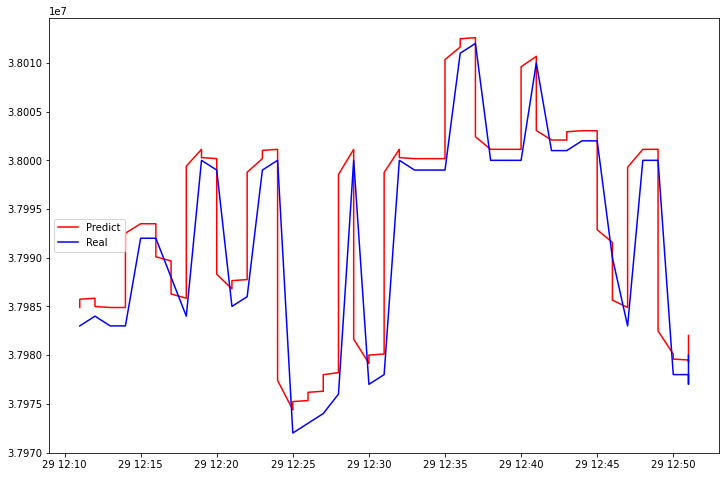

In [157]:
mylstm.predict_plot(pred1)

In [158]:
mylstm2 = My_Lstm()

In [159]:
# 가중치 로드
mylstm2.model_load(h5_name,compile=False,)

In [160]:
# 예측할 코인 ID
coinid = 'BTC'

# 시작가 or 종료가
col = 'close'

# 분봉 단위 및 day단위
interval = 'minute1'

# API를 통해서 가져올 데이터의 수
rows = 1000

In [161]:
# 데이터 가져오기
times, data = mud.load_ml_data(interval=interval, rows=rows)

In [162]:
# 예측전 모델 셋팅
mylstm2.train_data_load(data,col=col,scale=True,train_mode=False,interval='minute1')

In [163]:
# 50개만 예측 ex.(10분봉 5개)
mylstm2.predict_last_few(50,minutes=1)

1/1 [==============================] - 0s 16ms/step


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

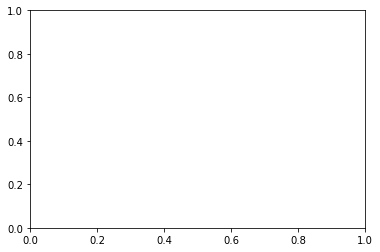

In [171]:
# 예측결과 plot으로 반환
mylstm2.plot_few_(coinid=coinid)